In [15]:
##### initialize libraries
library("corrplot")
library(ggplot2)
library(rpart)
library(class)
library(VIM)
library(caTools)
library(rfUtilities)
library(randomForest)
library(ROSE)

In [16]:
input <- read.csv('/home/vignesh/Documents/DataAnalyticsProject/datasets/Project_Data.csv')
####### factorize Y variables, Group and Response
input$Y1 <- factor(input$Y1)
input$Y2 <- factor(input$Y2)
input$Y3 <- factor(input$Y3)
input$Y4 <- factor(input$Y4)
input$Y5 <- factor(input$Y5)
input$Y6 <- factor(input$Y6)
input$Y7 <- factor(input$Y7)
input$Response <- factor(input$Response)
input$Group <- factor(input$Group)

In [17]:
####### Perform normalization
normalize <- function(x) {
return ((x - min(x, na.rm = TRUE)) / (max(x, na.rm = TRUE) - min(x, na.rm = TRUE)))}
input_unnorm <- input
input$X1 <- normalize(input$X1)
input$X4 <- normalize(input$X4)
input$X5 <- normalize(input$X5)
input$X6 <- normalize(input$X6)
input$X7 <- normalize(input$X7)

In [18]:
na_count <-sapply(input, function(y) sum(length(which(is.na(y)))))
print("############# missing value counts ######")
na_count

[1] "############# missing value counts ######"


ID Response    Group       X1       X2       X3       X4       X5 
       0        0        0        4      130      131        0        4 
      X6       X7       Y1       Y2       Y3       Y4       Y5       Y6 
      63       24        4      130      131        0        4       63 
      Y7 
      24

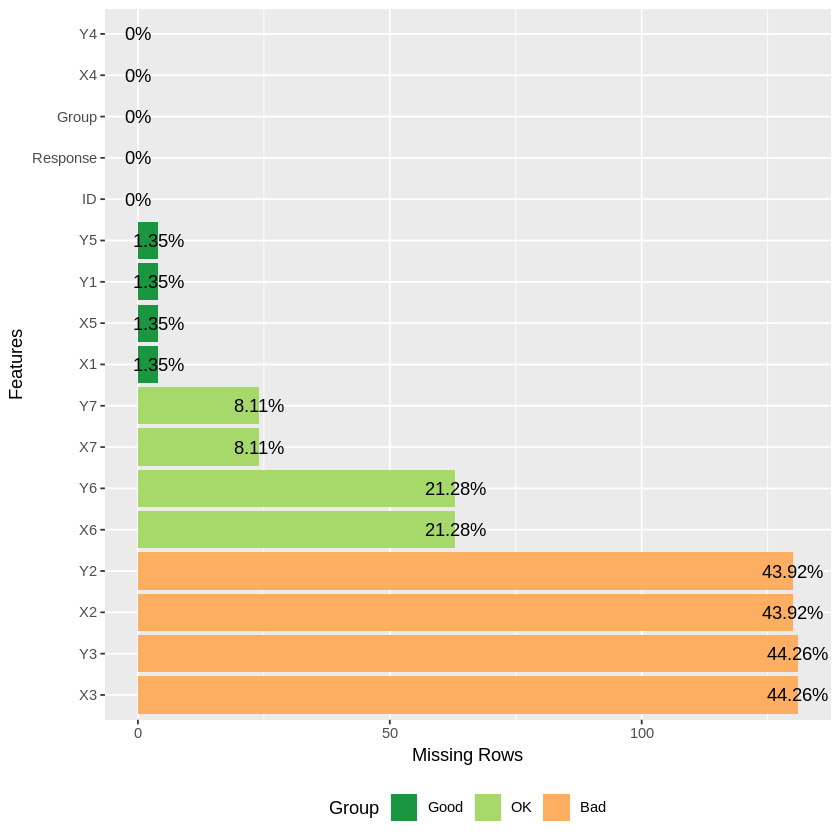

In [19]:
library('DataExplorer')
plot_missing(input)

In [49]:
# print('######## correlation matrix #########')
# cor(input,use = "complete.obs")

[1] "########### correlation matrix ###############"
[1] "########### X1,X2,X3 are multicollinear so ignore X2,X3 ###########"


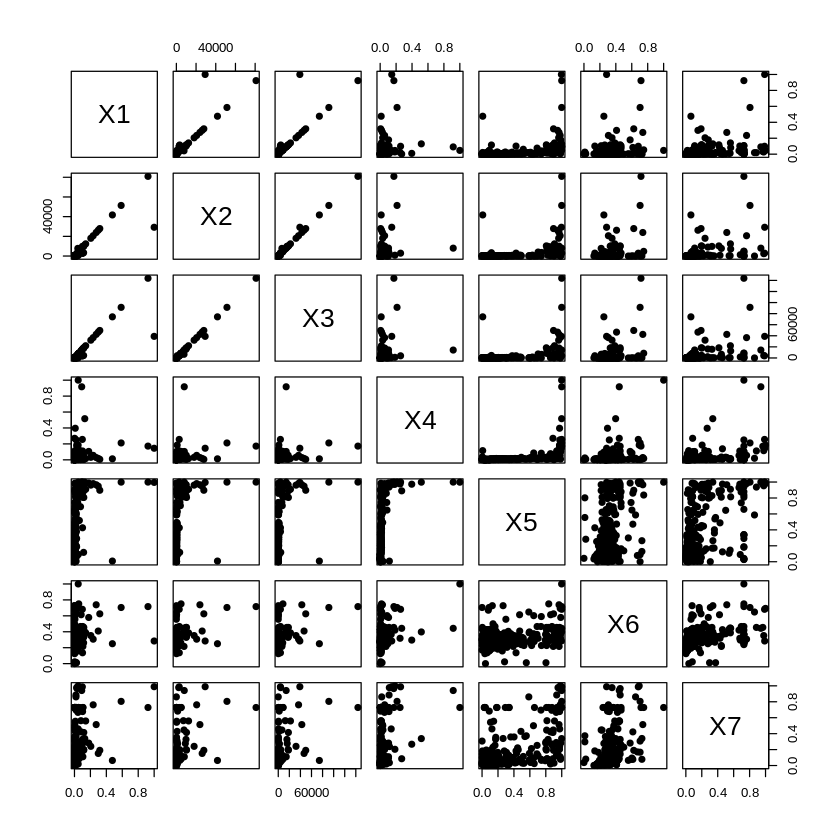

In [50]:
print("########### correlation matrix ###############")
pairs(input[,4:10], pch =19)
print("########### X1,X2,X3 are multicollinear so ignore X2,X3 ###########")

In [51]:
### Performing Mean Imputation of X1 and X5 since there are only four missing values ####

input[is.na(input$X1),c('X1')] <- as.integer(mean(input[!is.na(input$X1),c('X1')]))
input[is.na(input$X5),c('X5')] <- as.integer(mean(input[!is.na(input$X5),c('X5')]))

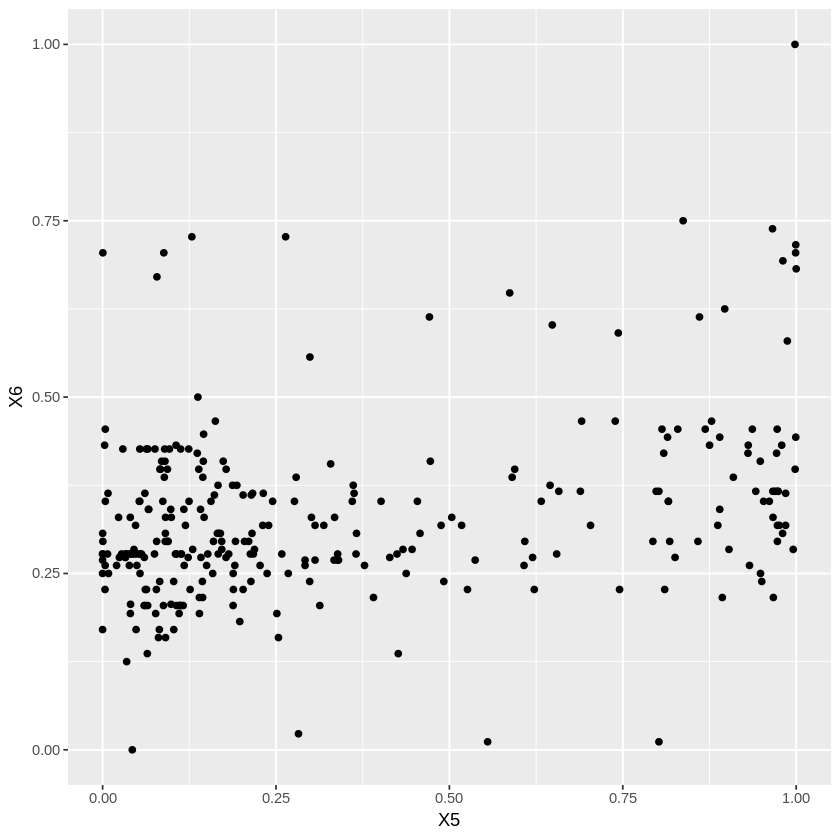

In [52]:
#### Plot of X5 vs X6 ##########
ggplot(input, aes(x=X5, y=X6)) + geom_point()

In [53]:
#### Split X6 into non-missing and missing data ######
X6nonMissing = input[!is.na(input$X6),1:length(input)]
X6Missing = input[is.na(input$X6),1:length(input)]


Regression tree:
rpart(formula = X6 ~ X3 + X5 + X7 + X4, data = X6nonMissing)

Variables actually used in tree construction:
[1] X3 X4 X5 X7

Root node error: 4.7733/296 = 0.016126

n= 296 

        CP nsplit rel error  xerror    xstd
1 0.191080      0   1.00000 1.01046 0.14669
2 0.085021      1   0.80892 0.84110 0.12527
3 0.014985      2   0.72390 0.90212 0.12966
4 0.014306      9   0.61294 1.00248 0.13899
5 0.010112     10   0.59864 0.99131 0.13298
6 0.010000     11   0.58852 0.96896 0.13138


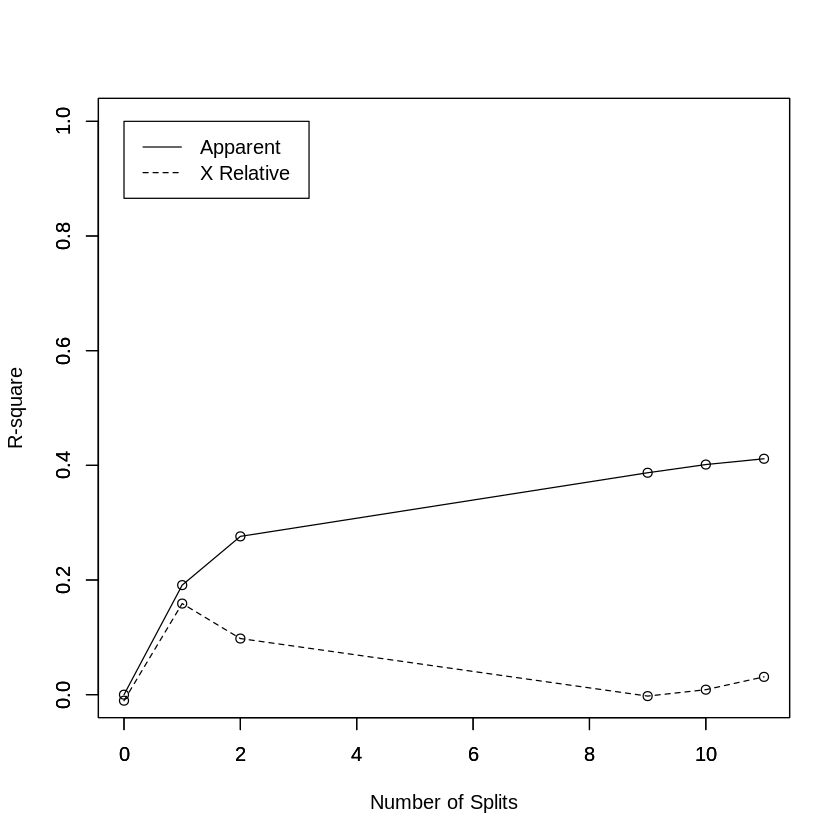

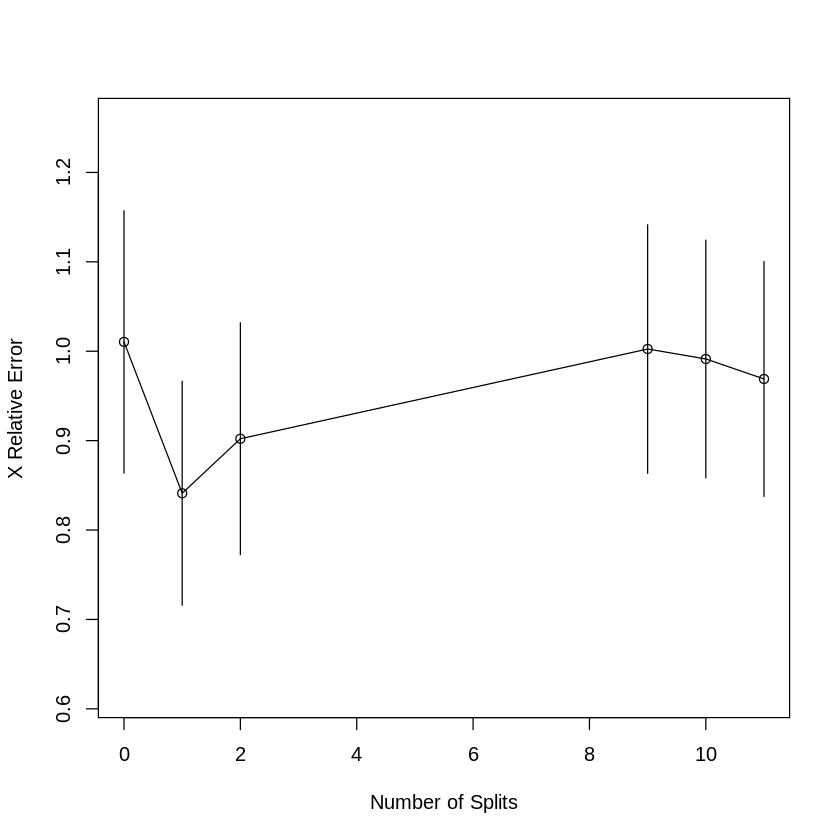

In [54]:
### Fit regression tree ########
regression <- rpart(formula = X6~X3+X5+X7+X4,data=X6nonMissing)
rsq.rpart(regression)

In [55]:
####### Impute X6 with imputed values
temp <- data.frame(cbind(X5<-X6Missing$X5,X7<-X6Missing$X7,X1<-X6Missing$X1,X4<-X6Missing$X4))
input[is.na(input$X6),'X6'] <- predict(regression,temp)

In [56]:
####### Perform normalization
normalize <- function(x) {
return ((x - min(x, na.rm = TRUE)) / (max(x, na.rm = TRUE) - min(x, na.rm = TRUE)))}
input_norm <- input
input_norm$X1 <- normalize(input$X1)
input_norm$X4 <- normalize(input$X4)
input_norm$X5 <- normalize(input$X5)
input_norm$X6 <- normalize(input$X6)
input_norm$X7 <- normalize(input$X7)

In [57]:
#### Split X7 into non-missing and missing data ######
X7nonMissing = input[!is.na(input$X7),1:length(input)]
X7Missing = input[is.na(input$X7),1:length(input)]


Regression tree:
rpart(formula = X7 ~ X5 + X4 + X1 + X6, data = X7nonMissing)

Variables actually used in tree construction:
[1] X1 X4 X5 X6

Root node error: 18.866/296 = 0.063735

n= 296 

        CP nsplit rel error  xerror     xstd
1 0.264357      0   1.00000 1.00539 0.108612
2 0.118508      1   0.73564 0.85267 0.090480
3 0.035317      2   0.61713 0.78196 0.089051
4 0.025945      3   0.58182 0.74976 0.086016
5 0.018224      4   0.55587 0.78618 0.086941
6 0.015036      5   0.53765 0.77781 0.084552
7 0.014503      6   0.52261 0.76618 0.083269
8 0.010000      7   0.50811 0.75960 0.082031


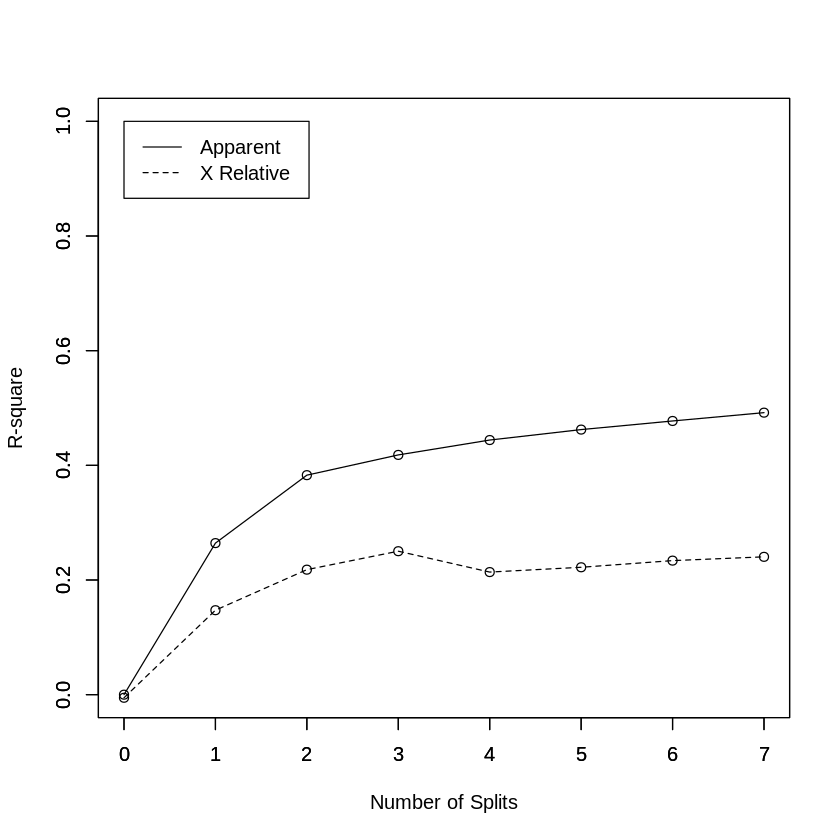

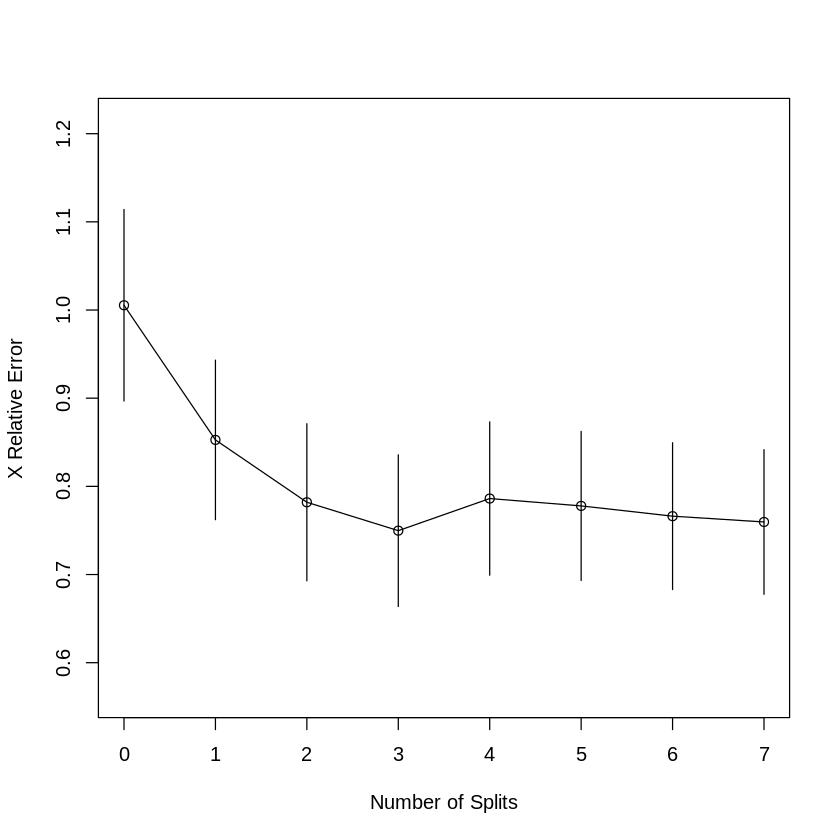

In [58]:
regression <- rpart(formula = X7~X5+X4+X1+X6,data=X7nonMissing)
rsq.rpart(regression)

In [59]:
####### Impute X7 with imputed values
temp <- data.frame(cbind(X5<-X7Missing$X5,X4<-X7Missing$X4,X1<-X7Missing$X1,X6<-X7Missing$X6))
input[is.na(input$X7),'X7'] <- predict(regression,temp)

In [60]:
####### Separate Y1 into missing and non-missing data
Y1nonMissing <- input[!is.na(input$Y1),c('X1','Y1')]
Y1Missing <- input[is.na(input$Y1),c('X1','Y1')]

In [61]:
####### 70-30 train and test split
trainIndex = sample(1:nrow(Y1nonMissing), size = round(0.7*nrow(Y1nonMissing)), replace=FALSE)
train = Y1nonMissing[trainIndex,]
test = Y1nonMissing[-trainIndex,]

In [62]:
###### Knn imputation can be used as it gave 100% accuracy on predicting Y1
pred <- knn(cbind(X1<-train$X1),cbind(X1<-test$X1),cl=train$Y1,k=5)
test$predicted <- pred

In [63]:
###### Knn imputation completed for Y1
temp <- input[c('X1','Y1')]
# temp$Y1 <- factor(Y1)
imputed <- kNN(temp,variable='Y1',k=5)
input[is.na(input$Y1),'Y1'] <- imputed[imputed$Y1_imp==TRUE,'Y1']

Warning message in kNN_work(as.data.table(data), variable, metric, k, dist_var, :
“Nothing to impute, because no NA are present (also after using makeNA)”

In [64]:
####### Separate Y5 into missing and non-missing data
Y5nonMissing <- input[!is.na(input$Y5),c('X5','Y5')]
Y5Missing <- input[is.na(input$Y5),c('X5','Y5')]

In [65]:
####### 70-30 train and test split
trainIndex = sample(1:nrow(Y5nonMissing), size = round(0.7*nrow(Y5nonMissing)), replace=FALSE)
train = Y5nonMissing[trainIndex,]
test = Y5nonMissing[-trainIndex,]

In [66]:
###### Knn imputation completed for Y5
temp <- input[c('X5','Y5')]
imputed <- kNN(temp,variable='Y5',k=5)
input[is.na(input$Y5),'Y5'] <- imputed[imputed$Y5_imp==TRUE,'Y5']

Warning message in kNN_work(as.data.table(data), variable, metric, k, dist_var, :
“Nothing to impute, because no NA are present (also after using makeNA)”

In [67]:
####### Separate Y6 into missing and non-missing data
Y6nonMissing <- input[!is.na(input$Y6),c('X6','Y6')]
Y6Missing <- input[is.na(input$Y6),c('X6','Y6')]

In [68]:
####### 70-30 train and test split
trainIndex = sample(1:nrow(Y6nonMissing), size = round(0.7*nrow(Y6nonMissing)), replace=FALSE)
train = Y6nonMissing[trainIndex,]
test = Y6nonMissing[-trainIndex,]

In [69]:
###### Knn imputation completed for Y6
temp <- input[c('X6','Y6')]
imputed <- kNN(temp,variable='Y6',k=5)
input[is.na(input$Y6),'Y6'] <- imputed[imputed$Y6_imp==TRUE,'Y6']

Warning message in kNN_work(as.data.table(data), variable, metric, k, dist_var, :
“Nothing to impute, because no NA are present (also after using makeNA)”

In [70]:
####### Separate Y7 into missing and non-missing data
Y7nonMissing <- input[!is.na(input$Y7),c('X7','Y7')]
Y7Missing <- input[is.na(input$Y7),c('X7','Y7')]

In [71]:
###### Knn imputation completed for Y6
temp <- input[c('X7','Y7')]
imputed <- kNN(temp,variable='Y7',k=5)
input[is.na(input$Y7),'Y7'] <- imputed[imputed$Y7_imp==TRUE,'Y7']

Warning message in kNN_work(as.data.table(data), variable, metric, k, dist_var, :
“Nothing to impute, because no NA are present (also after using makeNA)”

In [72]:
####### 80-20 train and test split
trainIndex = sample(1:nrow(input), size = round(0.8*nrow(input)), replace=FALSE)
train = input[trainIndex,]
test = input[-trainIndex,]

In [122]:
RF <- randomForest(formula = Response~X1+X4+X5+X6+Y1+Y4+Y5+Y6+Group,data = train,ntree = 300,
                      mtry = 4)

In [123]:
RF


Call:
 randomForest(formula = Response ~ X1 + X4 + X5 + X6 + Y1 + Y4 +      Y5 + Y6 + Group, data = train, ntree = 300, mtry = 4) 
               Type of random forest: classification
                     Number of trees: 300
No. of variables tried at each split: 4

        OOB estimate of  error rate: 23.21%
Confusion matrix:
    0  1 class.error
0 102 19   0.1570248
1  36 80   0.3103448

,MeanDecreaseGini
X1,25.910157
X4,35.777471
X5,27.913671
X6,16.719326
Y1,2.756460
Y4,2.124089
Y5,2.406076
Y6,1.751656
Group,2.141575


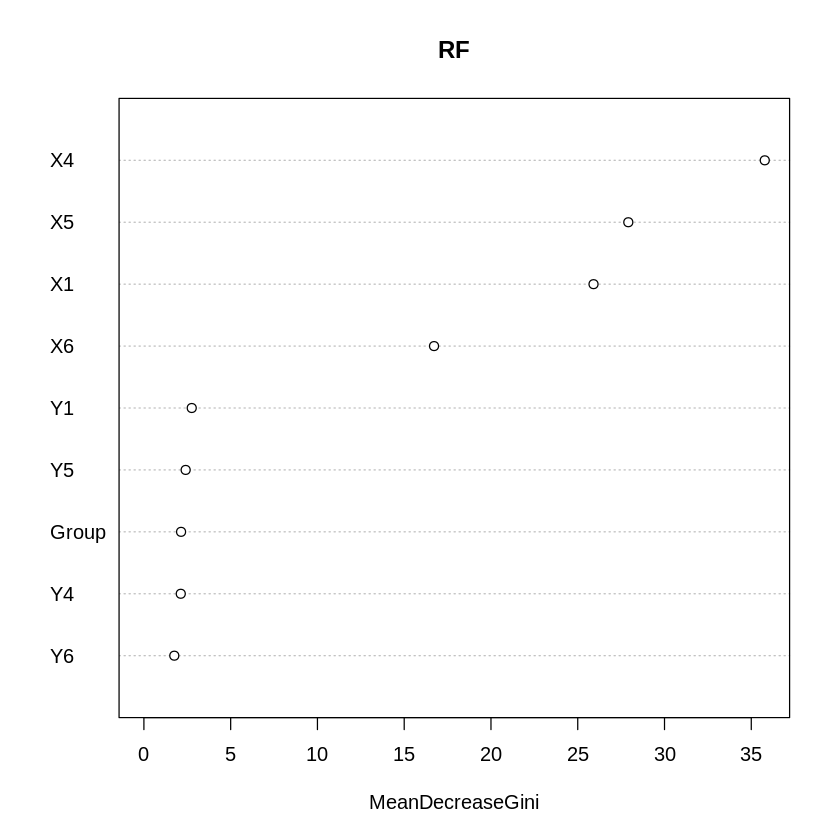

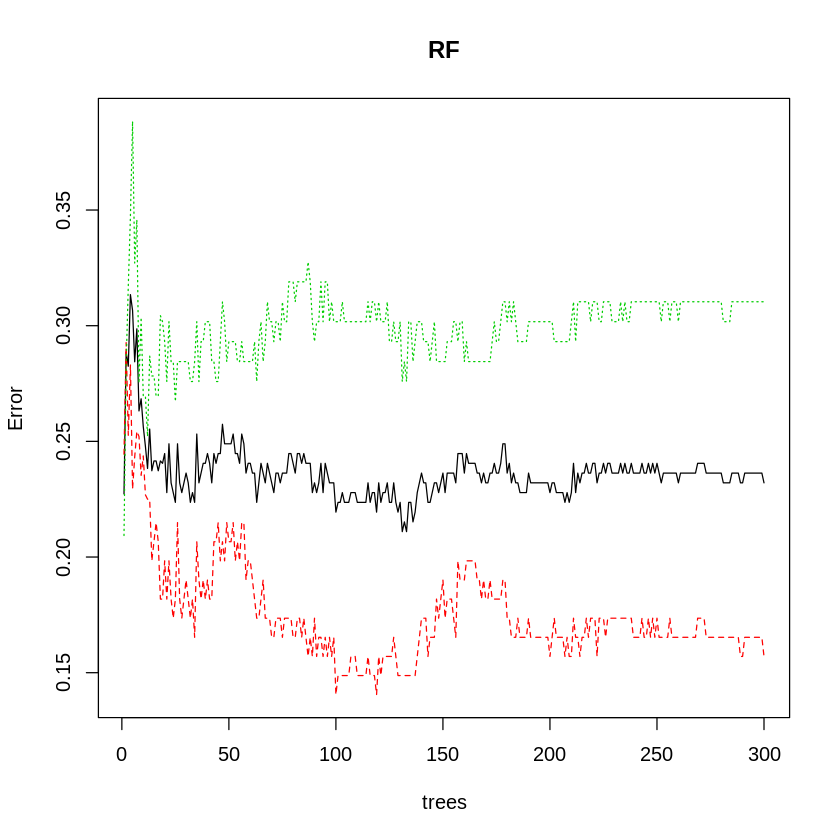

In [124]:
importance(RF)
varImpPlot(RF)
plot(RF)

In [128]:
test$pred_rf_log <- predict(RF,test[c('X1','X4','X5','X6','Y1','Y4','Y5','Y6','Group')],type='prob')[1:nrow(test)]

Area under the curve (AUC): 0.861

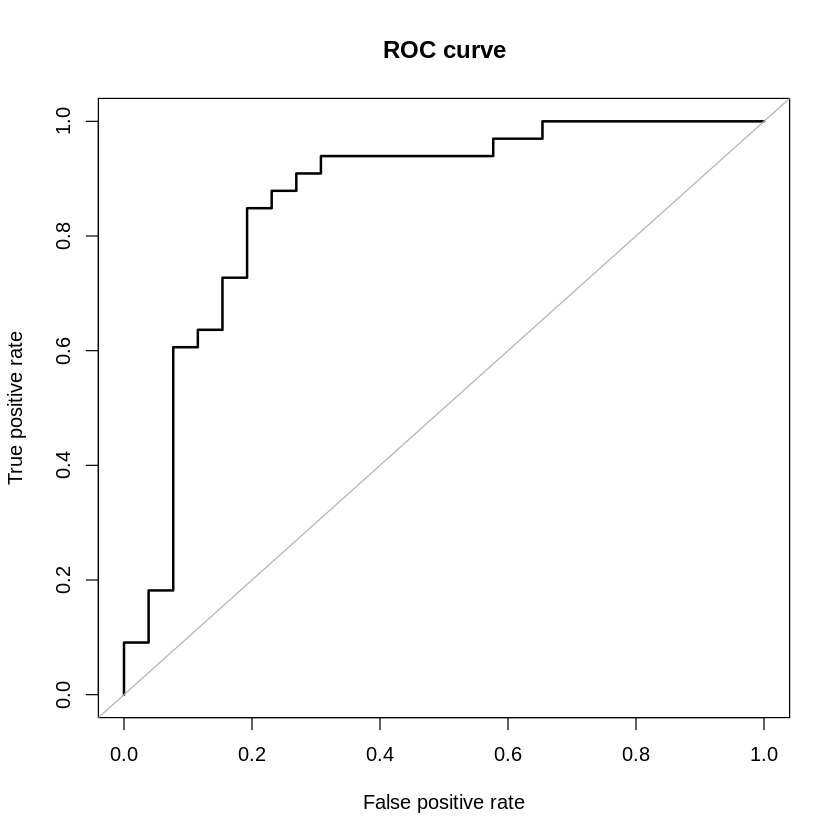

In [129]:
roc.curve(test$Response,test$pred_rf_log)

In [127]:
test$pred_rf <- predict(RF,test[c('X1','X4','X5','X6','Y1','Y4','Y5','Y6','Group')],type='class')
accuracy(test$pred_rf,test$Response)

,0,1
0,True positive(30),False positive(3)
1,False negative(8),True negative(18)


In [ ]:
############ Below code shows grid search with different params

In [685]:
hyper_grid <- expand.grid(
  mtry       = seq(2, 5, by = 1),
  ntree = seq(50,1000,by=50)
)
oob_1 = c()
oob_overall = c()
oob_0 = c()
for (i in 1:nrow(hyper_grid)){
    RF <- randomForest(formula = Response~X1+X4+X5+X6+X7+Group,data = train,ntree = hyper_grid$ntree[i],
                      mtry = hyper_grid$mtry[i])
#     print(hyper_grid$mtry[i])
#     print(hyper_grid$ntree[i])
#     print("#############")
#     print(RF$err.rate[hyper_grid$ntree[i],])
#     print(paste0(hyper_grid$mtry[i],"  ",hyper_grid$ntree[i]," ",RF$err.rate[hyper_grid$ntree[i],3],"\n"))
    oob_overall = c(oob_overall,RF$err.rate[hyper_grid$ntree[i],1])
    oob_0 = c(oob_0,RF$err.rate[hyper_grid$ntree[i],2])
    oob_1 = c(oob_1,RF$err.rate[hyper_grid$ntree[i],3])
}

result<-data.frame(mtry=hyper_grid$mtry[1:nrow(hyper_grid)],ntree=hyper_grid$ntree,oob_overall=oob_overall,oob_0=oob_0,oob_1=oob_1)
result[result$oob_overall==min(result$oob_overall),]
######## choose mtry=3, ntree=150

,mtry,ntree,oob_overall,oob_0,oob_1
12,5,150,0.2025316,0.1570248,0.2500000
18,3,250,0.2025316,0.1570248,0.2500000
54,3,700,0.2025316,0.1404959,0.2672414


In [99]:
hyper_grid <- expand.grid(
  mtry       = seq(2, 5, by = 1),
  ntree = seq(50,1000,by=50)
)
oob_1 = c()
oob_overall = c()
oob_0 = c()
for (i in 1:nrow(hyper_grid)){
    RF <- randomForest(formula = Response~X1+X4+X5+X6+Group,data = train,ntree = hyper_grid$ntree[i],
                      mtry = hyper_grid$mtry[i])
#     print(hyper_grid$mtry[i])
#     print(hyper_grid$ntree[i])
#     print("#############")
#     print(RF$err.rate[hyper_grid$ntree[i],])
#     print(paste0(hyper_grid$mtry[i],"  ",hyper_grid$ntree[i]," ",RF$err.rate[hyper_grid$ntree[i],3],"\n"))
    oob_overall = c(oob_overall,RF$err.rate[hyper_grid$ntree[i],1])
    oob_0 = c(oob_0,RF$err.rate[hyper_grid$ntree[i],2])
    oob_1 = c(oob_1,RF$err.rate[hyper_grid$ntree[i],3])
}

result<-data.frame(mtry=hyper_grid$mtry[1:nrow(hyper_grid)],ntree=hyper_grid$ntree,oob_overall=oob_overall,oob_0=oob_0,oob_1=oob_1)
result[result$oob_overall==min(result$oob_overall),]
######## choose mtry=3, ntree=600

,mtry,ntree,oob_overall,oob_0,oob_1
26,3,350,0.2194093,0.1487603,0.2931034
50,3,650,0.2194093,0.1487603,0.2931034


In [694]:
hyper_grid <- expand.grid(
  mtry       = seq(2, 4, by = 1),
  ntree = seq(50,1000,by=50)
)
oob_1 = c()
oob_overall = c()
oob_0 = c()
for (i in 1:nrow(hyper_grid)){
    RF <- randomForest(formula = Response~X1+X4+X5+Group,data = train,ntree = hyper_grid$ntree[i],
                      mtry = hyper_grid$mtry[i])
#     print(hyper_grid$mtry[i])
#     print(hyper_grid$ntree[i])
#     print("#############")
#     print(RF$err.rate[hyper_grid$ntree[i],])
#     print(paste0(hyper_grid$mtry[i],"  ",hyper_grid$ntree[i]," ",RF$err.rate[hyper_grid$ntree[i],3],"\n"))
    oob_overall = c(oob_overall,RF$err.rate[hyper_grid$ntree[i],1])
    oob_0 = c(oob_0,RF$err.rate[hyper_grid$ntree[i],2])
    oob_1 = c(oob_1,RF$err.rate[hyper_grid$ntree[i],3])
#     print(RF$err.rate)
}

result<-data.frame(mtry=hyper_grid$mtry[1:nrow(hyper_grid)],ntree=hyper_grid$ntree,oob_overall=oob_overall,oob_0=oob_0,oob_1=oob_1)
result[result$oob_overall==min(result$oob_overall),]
######## choose mtry=4, ntree=50

,mtry,ntree,oob_overall,oob_0,oob_1
2,3,50,0.2995781,0.231405,0.3706897


In [737]:
randomForest(formula = Response~X1+X4+X5+Group,data = train,ntree = 150,mtry = 4)C


Call:
 randomForest(formula = Response ~ X1 + X4 + X5 + Group, data = train,      ntree = 150, mtry = 4) 
               Type of random forest: classification
                     Number of trees: 150
No. of variables tried at each split: 4

        OOB estimate of  error rate: 32.49%
Confusion matrix:
   0  1 class.error
0 87 34   0.2809917
1 43 73   0.3706897

In [703]:
library(caret)
# Folds are created on the basis of target variable
folds <- createFolds(train$Response, k = 3, list = TRUE)

In [ ]:
hyper_grid <- expand.grid(
  mtry       = seq(2, 5, by = 1),
  ntree = seq(50,1000,by=50)
)
oob_1 = c()
oob_overall = c()
oob_0 = c()
for (i in 1:nrow(hyper_grid)){
    RF <- randomForest(formula = Response~X1+X4+X5+X6+X7+Group,data = train,ntree = hyper_grid$ntree[i],
                      mtry = hyper_grid$mtry[i])
#     print(hyper_grid$mtry[i])
#     print(hyper_grid$ntree[i])
#     print("#############")
#     print(RF$err.rate[hyper_grid$ntree[i],])
#     print(paste0(hyper_grid$mtry[i],"  ",hyper_grid$ntree[i]," ",RF$err.rate[hyper_grid$ntree[i],3],"\n"))
    oob_overall = c(oob_overall,RF$err.rate[hyper_grid$ntree[i],1])
    oob_0 = c(oob_0,RF$err.rate[hyper_grid$ntree[i],2])
    oob_1 = c(oob_1,RF$err.rate[hyper_grid$ntree[i],3])
}

result<-data.frame(mtry=hyper_grid$mtry[1:nrow(hyper_grid)],ntree=hyper_grid$ntree,oob_overall=oob_overall,oob_0=oob_0,oob_1=oob_1)
result[result$oob_overall==min(result$oob_overall),]
######## choose mtry=3, ntree=150

In [744]:
for (i in 1:3){
    validation <- data.frame(train[unlist(folds[i]),])
#     print(validation[1:10])
    rf1 <- randomForest(formula = Response~X1+X4+X5+Group,data = validation,ntree = 150,mtry = 4)
    print(rf1)
}


Call:
 randomForest(formula = Response ~ X1 + X4 + X5 + Group, data = validation,      ntree = 150, mtry = 4) 
               Type of random forest: classification
                     Number of trees: 150
No. of variables tried at each split: 4

        OOB estimate of  error rate: 35.44%
Confusion matrix:
   0  1 class.error
0 26 14   0.3500000
1 14 25   0.3589744

Call:
 randomForest(formula = Response ~ X1 + X4 + X5 + Group, data = validation,      ntree = 150, mtry = 4) 
               Type of random forest: classification
                     Number of trees: 150
No. of variables tried at each split: 4

        OOB estimate of  error rate: 41.77%
Confusion matrix:
   0  1 class.error
0 25 16   0.3902439
1 17 21   0.4473684

Call:
 randomForest(formula = Response ~ X1 + X4 + X5 + Group, data = validation,      ntree = 150, mtry = 4) 
               Type of random forest: classification
                     Number of trees: 150
No. of variables tried at each split: 4

        OOB 

In [118]:
hyper_grid <- expand.grid(
  mtry       = seq(2, 3, by = 1),
  ntree = seq(50,1000,by=50)
)
oob_1 = c()
oob_overall = c()
oob_0 = c()
for (i in 1:nrow(hyper_grid)){
    RF <- randomForest(formula = Response~X1+X4+X5+X6+Y1+Y4+Y5+Y6+Group,data = train,ntree = hyper_grid$ntree[i],
                      mtry = hyper_grid$mtry[i])
#     print(hyper_grid$mtry[i])
#     print(hyper_grid$ntree[i])
#     print("#############")
#     print(RF$err.rate[hyper_grid$ntree[i],])
#     print(paste0(hyper_grid$mtry[i],"  ",hyper_grid$ntree[i]," ",RF$err.rate[hyper_grid$ntree[i],3],"\n"))
    oob_overall = c(oob_overall,RF$err.rate[hyper_grid$ntree[i],1])
    oob_0 = c(oob_0,RF$err.rate[hyper_grid$ntree[i],2])
    oob_1 = c(oob_1,RF$err.rate[hyper_grid$ntree[i],3])
}

result<-data.frame(mtry=hyper_grid$mtry[1:nrow(hyper_grid)],ntree=hyper_grid$ntree,oob_overall=oob_overall,oob_0=oob_0,oob_1=oob_1)
result[result$oob_overall==min(result$oob_overall),]
######## choose mtry=3, ntree=600

,mtry,ntree,oob_overall,oob_0,oob_1
5,2,150,0.2194093,0.1570248,0.2844828
6,3,150,0.2194093,0.1570248,0.2844828
20,3,500,0.2194093,0.1487603,0.2931034


In [103]:
hyper_grid <- expand.grid(
  mtry       = seq(2, 4, by = 1),
  ntree = seq(50,1000,by=50)
)
oob_1 = c()
oob_overall = c()
oob_0 = c()
for (i in 1:nrow(hyper_grid)){
    RF <- randomForest(formula = Response~X1+X4+X5+X6+Y1+Y4+Y5+Y6,data = train,ntree = hyper_grid$ntree[i],
                      mtry = hyper_grid$mtry[i])
#     print(hyper_grid$mtry[i])
#     print(hyper_grid$ntree[i])
#     print("#############")
#     print(RF$err.rate[hyper_grid$ntree[i],])
#     print(paste0(hyper_grid$mtry[i],"  ",hyper_grid$ntree[i]," ",RF$err.rate[hyper_grid$ntree[i],3],"\n"))
    oob_overall = c(oob_overall,RF$err.rate[hyper_grid$ntree[i],1])
    oob_0 = c(oob_0,RF$err.rate[hyper_grid$ntree[i],2])
    oob_1 = c(oob_1,RF$err.rate[hyper_grid$ntree[i],3])
}

result<-data.frame(mtry=hyper_grid$mtry[1:nrow(hyper_grid)],ntree=hyper_grid$ntree,oob_overall=oob_overall,oob_0=oob_0,oob_1=oob_1)
result[result$oob_overall==min(result$oob_overall),]
######## choose mtry=3, ntree=600

,mtry,ntree,oob_overall,oob_0,oob_1
9,4,150,0.2025316,0.1157025,0.2931034
